In [1]:

from inspect import trace
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as wb
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from tqdm.auto import tqdm
import os


In [104]:
prices = pdr.get_data_yahoo(('F', 'MSFT'))

[*********************100%***********************]  2 of 2 completed


In [105]:
prices = prices[['Adj Close']].dropna()
prices.head()

Adj Close          
                   F      MSFT
Date                          
1986-03-13  1.117789  0.060524
1986-03-14  1.125472  0.062686
1986-03-17  1.115868  0.063767
1986-03-18  1.127392  0.062145
1986-03-19  1.167724  0.061065

In [106]:
import sys
sys.path.append("../")


In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import warnings
warnings.filterwarnings('ignore')

In [109]:
def statsGen(data):
    
    adjClose = data.iloc[:, :2]
    result = coint_johansen(adjClose, det_order=0, k_ar_diff=1)
    
    return result.lr1, result.cvt, result.lr2, result.cvm, result.evec
    

ADF Statistic: 1.343664
p-value: 0.996843


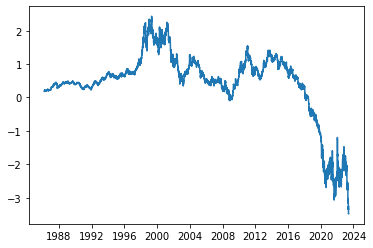

In [110]:
results = coint_johansen(prices, det_order=0, k_ar_diff=1)
results.lr1, results.cvt, results.lr2, results.cvm, results.evec

top_eigenvec = results.evec[:, 0]
# build the portfolio
portfolio = pd.DataFrame()
portfolio['stock_1'] = prices.iloc[:, 0]
portfolio['stock_2'] = prices.iloc[:, 1]
portfolio['prices'] = top_eigenvec[0] * portfolio['stock_1'] + top_eigenvec[1] * portfolio['stock_2']


# test if this series is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(portfolio['prices'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

plt.plot(portfolio['prices'])


In [111]:
print(results.lr1)
print(results.cvt)
print(results.lr2)
print(results.cvm)

[19.53380264  6.20771255]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[13.32609009  6.20771255]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [53]:
results.evec

array([[ 0.00673349,  0.01831844],
       [ 0.10548619, -0.02848487]])

In [54]:
# cwd = os.getcwd()
# # get rid of the last folder
# cwd = os.path.dirname(cwd)

# stationary = []
# sss = pd.DataFrame(columns=['symb1', 'symb2'])
# path = os.path.join(cwd, 'Cointegrated_Pairs', 'pairs.csv')
# data = pd.read_csv(path)
# for i in range(len(data)):
#     tickers = (data['symb1'][i], data['symb2'][i])

#     prices = wb.DataReader(tickers, data_source='yahoo', interval='1d')['Adj Close']
#     prices = prices.dropna()
#     info = statsGen(prices)
#     lr_stats = info[0][0]
#     lr_90pct_threshold = info[1][0][0]
#     mle_stats = info[2][0]
#     mle_90pct_threshold = info[3][0][0]
    
#     if lr_stats > lr_90pct_threshold and mle_stats > mle_90pct_threshold:
#         stationary.append(tickers)
#         sss = sss.append({'symb1': tickers[0], 'symb2': tickers[1]}, ignore_index=True)
        
# print(len(stationary)/len(data))

In [189]:
tickers = ('AMC', 'MSFT')

data = wb.DataReader(tickers, data_source='yahoo', interval='1d')[['Adj Close']]

data = data.dropna()
data

[*********************100%***********************]  2 of 2 completed


Adj Close            
                  AMC        MSFT
Date                             
2013-12-18  13.593413   30.930298
2013-12-19  14.017754   30.651266
2013-12-20  14.154408   31.116320
2013-12-23  14.197563   30.964125
2013-12-24  14.046526   31.353069
...               ...         ...
2023-05-22   5.120000  321.179993
2023-05-23   5.030000  315.260010
2023-05-24   4.880000  313.850006
2023-05-25   4.700000  325.920013
2023-05-26   4.640000  332.890015

[2376 rows x 2 columns]

In [190]:
data[f'coef_{tickers[0]}'] = None
data[f'coef_{tickers[1]}'] = None
data['portfolio'] = None
data


Adj Close             coef_AMC coef_MSFT portfolio
                  AMC        MSFT                             
Date                                                          
2013-12-18  13.593413   30.930298     None      None      None
2013-12-19  14.017754   30.651266     None      None      None
2013-12-20  14.154408   31.116320     None      None      None
2013-12-23  14.197563   30.964125     None      None      None
2013-12-24  14.046526   31.353069     None      None      None
...               ...         ...      ...       ...       ...
2023-05-22   5.120000  321.179993     None      None      None
2023-05-23   5.030000  315.260010     None      None      None
2023-05-24   4.880000  313.850006     None      None      None
2023-05-25   4.700000  325.920013     None      None      None
2023-05-26   4.640000  332.890015     None      None      None

[2376 rows x 5 columns]

In [191]:
# for every entry, use all previous closing prices as input to the cointegration test
# return the results for every week entry
# before market close, eigenvalue and eigenvector are calculated and will be kept for the next week
# since eigenvector changes, high loww should be fouund using combination of high and low of the week


for i in tqdm(range(50, len(data))):

    evec = statsGen(data.iloc[:i+1,:])[4][:, 0]
    coef1 = evec[0]
    coef2 = evec[1]
    data.iloc[i, -3] = coef1
    data.iloc[i, -2] = coef2
    
    if i!=len(data)-1:
        data.iloc[i, -1] = coef1 * data.iloc[i, 0] + coef2 * data.iloc[i, 1]

    
        
    
    
    

# print("Eigenvalue: \n", eigenvalue)
# print("Eigenvector: \n", eigenvector)
# print("\n")
# print("Maximum eigenvalue statistic: \n", max_eigen_statistic)
# print("Critical values (90%, 95%, 99%) of maximum eigenvalue statistic. \n", cvm)
# print("\n")
# print("Trace statistic: \n", trace_statistic)
# print("Critical values (90%, 95%, 99%) of trace statistic. \n", cvt)

100%|██████████| 2326/2326 [00:04<00:00, 526.94it/s]


In [192]:
data

Adj Close              coef_AMC coef_MSFT portfolio
                  AMC        MSFT                              
Date                                                           
2013-12-18  13.593413   30.930298      None      None      None
2013-12-19  14.017754   30.651266      None      None      None
2013-12-20  14.154408   31.116320      None      None      None
2013-12-23  14.197563   30.964125      None      None      None
2013-12-24  14.046526   31.353069      None      None      None
...               ...         ...       ...       ...       ...
2023-05-22   5.120000  321.179993  0.106383  0.003215  1.577234
2023-05-23   5.030000  315.260010  0.106395  0.003216  1.549194
2023-05-24   4.880000  313.850006  0.106385  0.003228   1.53218
2023-05-25   4.700000  325.920013  0.106246  0.003292  1.572329
2023-05-26   4.640000  332.890015   0.10616  0.003333      None

[2376 rows x 5 columns]

In [193]:
# get rid of all datas before the last None value
adjdata = data.dropna()
adjdata = adjdata[1500:]

In [194]:
adjdata

Adj Close              coef_AMC coef_MSFT portfolio
                 AMC        MSFT                              
Date                                                          
2020-02-18  6.997073  181.170883  0.002141  0.028826  5.237333
2020-02-19  7.265427  181.714218  0.005186 -0.027976 -5.045972
2020-02-20  7.712683  178.939240  0.019094 -0.026366 -4.570607
2020-02-21  7.414512  173.282501  0.019369  0.030319  5.397403
2020-02-24  7.007012  165.811371  0.252327  0.037814  8.038133
...              ...         ...       ...       ...       ...
2023-05-19  5.030000  318.339996  0.106369  0.003214  1.558096
2023-05-22  5.120000  321.179993  0.106383  0.003215  1.577234
2023-05-23  5.030000  315.260010  0.106395  0.003216  1.549194
2023-05-24  4.880000  313.850006  0.106385  0.003228   1.53218
2023-05-25  4.700000  325.920013  0.106246  0.003292  1.572329

[825 rows x 5 columns]

In [195]:
# vecm
# Delta y_t = A_1 Delta y_{t-1} + ... + A_p Delta y_{t-p} + B (y_{t-1} - Π y_{t-1}) + e_t


# where:

# y_t is a vector of the original time series at time t
# Delta y_t is the first difference of y_t, which can be used to remove any trend or drift in the series
# A_1, ..., A_p are the short-term dynamics of the model, which capture the dependence of the series on their past values
# B is a matrix of coefficients that represent the long-term relationships among the series, which capture the cointegrating relationships
# Π is a matrix of lagged coefficients that represent the adjustment towards equilibrium
# e_t is a vector of errors or residuals at time t
# In this equation, the matrix B represents the coefficients of the original time series in the linear combinations that form the cointegrating relationships. The columns of B correspond to the eigenvectors obtained from the coint_johansen test.

# For example, suppose you have two time series, X and Y, and you want to determine whether they are cointegrated. You can run the coint_johansen test on the data and obtain the eigenvectors [a, b] and [c, d], which represent the two linear combinations aX + bY and cX + dY.

# You can then use these eigenvectors to construct the VECM for the two series, which would take the form:
    
# Delta [X_t, Y_t] = A_1 Delta [X_{t-1}, Y_{t-1}] + ... + 
# A_p Delta [X_{t-p}, Y_{t-p}] + B ([X_{t-1}, Y_{t-1}] - Π [X_{t-1}, Y_{t-1}]) + e_t
# where:

# X_t and Y_t are the original time series at time t
# B is a matrix with columns [a, b] and [c, d], representing the linear combinations aX + bY and cX + dY

# cointegration不代表要一起动, unless correlation is high, otherwise, moving one can change the portfolio too. 
# 只是给你stationary portfolio, nothing to do with hedging
# based on the coefficients, you can tell which one will generate more effect and trade on that
# trends need to be matched


In [196]:
adjdata['rolling_mean'] = adjdata['portfolio'].expanding().mean()


ADF Statistic: -2.655858
p-value: 0.081993


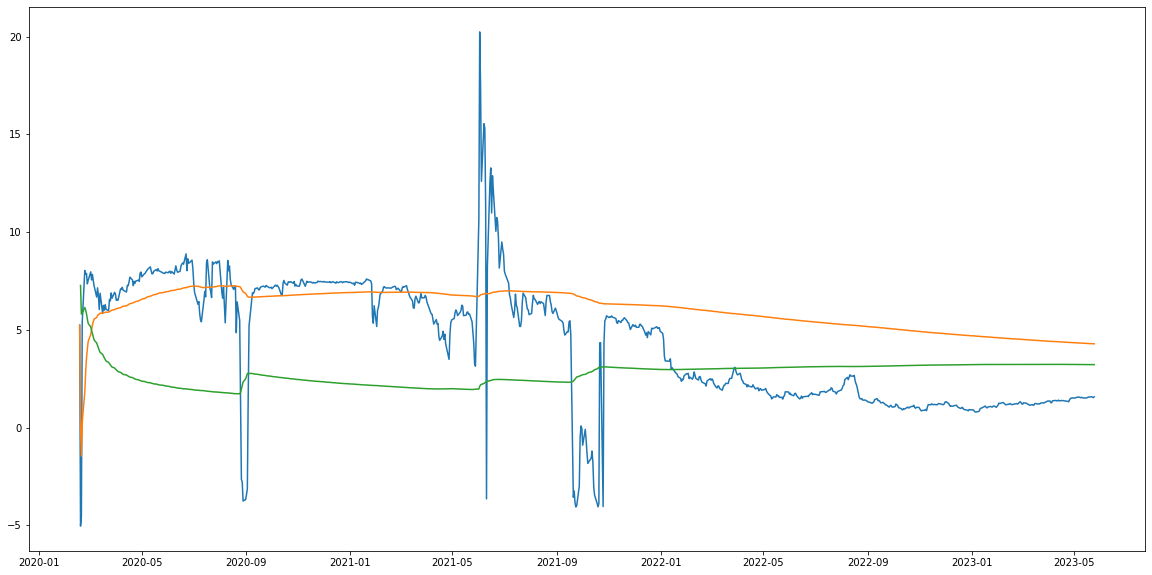

In [197]:
# plot the portfolio
plt.figure(figsize=(20, 10))
plt.plot(adjdata['portfolio'])
plt.plot(adjdata['rolling_mean'])

# test if this series is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(adjdata['portfolio'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

adjdata['rolling_std'] = adjdata['portfolio'].expanding().std()
plt.plot(adjdata['rolling_std'])


In [198]:
adjdata

Adj Close              coef_AMC coef_MSFT portfolio rolling_mean  \
                 AMC        MSFT                                              
Date                                                                          
2020-02-18  6.997073  181.170883  0.002141  0.028826  5.237333     5.237333   
2020-02-19  7.265427  181.714218  0.005186 -0.027976 -5.045972     0.095681   
2020-02-20  7.712683  178.939240  0.019094 -0.026366 -4.570607    -1.459749   
2020-02-21  7.414512  173.282501  0.019369  0.030319  5.397403     0.254539   
2020-02-24  7.007012  165.811371  0.252327  0.037814  8.038133     1.811258   
...              ...         ...       ...       ...       ...          ...   
2023-05-19  5.030000  318.339996  0.106369  0.003214  1.558096     4.297185   
2023-05-22  5.120000  321.179993  0.106383  0.003215  1.577234     4.293876   
2023-05-23  5.030000  315.260010  0.106395  0.003216  1.549194     4.290541   
2023-05-24  4.880000  313.850006  0.106385  0.003228   1.53218     4.287193   
2023-05-25  4.700000  325.920013  0.106246  0.003292  1.572329     4.283902   

           rolling_std  
                        
Date                    
2020-02-18         NaN  
2020-02-19    7.271395  
2020-02-20    5.804711  
2020-02-21    5.849637  
2020-02-24    6.146589  
...                ...  
2023-05-19    3.221254  
2023-05-22    3.220689  
2023-05-23    3.220151  
2023-05-24    3.219629  
2023-05-25    3.219062  

[825 rows x 7 columns]

In [199]:
# strat 1: simply trade when reach bottom or top 10%

adjdata['entry'] = 0

def entrypoint(data):
    
    # long run expectation, wait for four trading years
    for i in range(1, len(data)):
        historical = data.iloc[:i, :]
        today_value = data.iloc[i, -4]

        above = historical[historical['portfolio'] >= today_value].shape[0] / historical.shape[0]
        below = historical[historical['portfolio'] <= today_value].shape[0] / historical.shape[0]
        if above < 0.025:
            data.iloc[i, -1] = -1
        elif below < 0.025:
            data.iloc[i, -1] = 1
        else:
            data.iloc[i, -1] = 0
            
    return data

adjdata = entrypoint(adjdata)
adjdata

Adj Close              coef_AMC coef_MSFT portfolio rolling_mean  \
                 AMC        MSFT                                              
Date                                                                          
2020-02-18  6.997073  181.170883  0.002141  0.028826  5.237333     5.237333   
2020-02-19  7.265427  181.714218  0.005186 -0.027976 -5.045972     0.095681   
2020-02-20  7.712683  178.939240  0.019094 -0.026366 -4.570607    -1.459749   
2020-02-21  7.414512  173.282501  0.019369  0.030319  5.397403     0.254539   
2020-02-24  7.007012  165.811371  0.252327  0.037814  8.038133     1.811258   
...              ...         ...       ...       ...       ...          ...   
2023-05-19  5.030000  318.339996  0.106369  0.003214  1.558096     4.297185   
2023-05-22  5.120000  321.179993  0.106383  0.003215  1.577234     4.293876   
2023-05-23  5.030000  315.260010  0.106395  0.003216  1.549194     4.290541   
2023-05-24  4.880000  313.850006  0.106385  0.003228   1.53218     4.287193   
2023-05-25  4.700000  325.920013  0.106246  0.003292  1.572329     4.283902   

           rolling_std entry  
                              
Date                          
2020-02-18         NaN     0  
2020-02-19    7.271395     1  
2020-02-20    5.804711     0  
2020-02-21    5.849637    -1  
2020-02-24    6.146589    -1  
...                ...   ...  
2023-05-19    3.221254     0  
2023-05-22    3.220689     0  
2023-05-23    3.220151     0  
2023-05-24    3.219629     0  
2023-05-25    3.219062     0  

[825 rows x 8 columns]

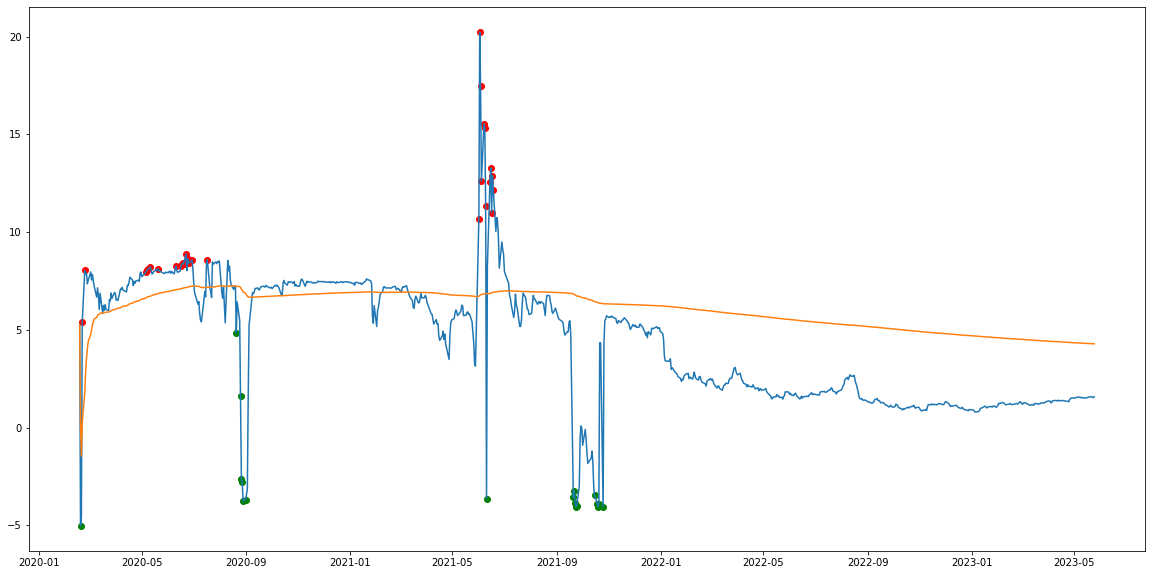

In [200]:
longing = adjdata[adjdata['entry'] == 1].index
shorting = adjdata[adjdata['entry'] == -1].index

# mark this point on the line chart with different color
plt.figure(figsize=(20, 10))
plt.plot(adjdata['portfolio'])
plt.plot(adjdata['rolling_mean'])
plt.scatter(longing, adjdata.loc[longing, 'portfolio'], color='g')
plt.scatter(shorting, adjdata.loc[shorting, 'portfolio'], color='r')


In [202]:
adjdata[adjdata['entry'] == -1]

Adj Close              coef_AMC coef_MSFT  portfolio rolling_mean  \
                  AMC        MSFT                                               
Date                                                                            
2020-02-21   7.414512  173.282501  0.019369  0.030319   5.397403     0.254539   
2020-02-24   7.007012  165.811371  0.252327  0.037814   8.038133     1.811258   
2020-05-06   3.920000  177.115112  0.234293  0.039877   7.981231     6.644594   
2020-05-07   3.990000  178.143616  0.233696  0.039901    8.04059     6.669085   
2020-05-08   4.100000  179.191498  0.234029   0.03988   8.105673     6.693854   
2020-05-11   5.320000  181.190323  0.257396  0.037836   8.224806     6.719802   
2020-05-20   4.660000  180.644119  0.251967  0.038538   8.135814     6.855593   
2020-06-10   6.290000  191.522079  0.272409  0.034258   8.274688     7.051222   
2020-06-16   5.560000  188.340439  0.267281  0.036012   8.268688     7.099673   
2020-06-17   5.420000  188.992294  0.264115  0.036686   8.364786     7.114556   
2020-06-18   5.630000  191.016113  0.266256  0.036234   8.420391     7.129740   
2020-06-19   5.520000  189.877716  0.265846  0.036307    8.36136     7.143897   
2020-06-22   5.330000  195.151306  0.223704  0.039433   8.887652     7.163712   
2020-06-24   4.790000  192.495026   0.22099   0.03937   8.636991     7.189676   
2020-06-26   4.180000  191.025833  0.222715  0.039274   8.433322     7.216521   
2020-06-29   4.420000  193.078842  0.227118  0.039183   8.569192     7.231066   
2020-07-17   4.270000  197.398895  0.228539  0.038553   8.586177     7.184879   
2021-06-01  32.040001  243.046844  0.140176  0.025386  10.661184     6.714628   
2021-06-02  62.549999  242.948639  0.223503   0.02581  20.250715     6.756150   
2021-06-03  51.340000  241.386612  0.219647  0.025812   17.50743     6.789028   
2021-06-04  47.910000  246.377213  0.137392  0.024429  12.601288     6.806749   
2021-06-07  55.000000  249.344055  0.172191  0.024396  15.553529     6.833335   
2021-06-08  55.049999  248.125900  0.170754   0.02387  15.322711     6.859060   
2021-06-09  49.340000  249.127930  0.114871  0.022745  11.334149     6.872580   
2021-06-14  57.000000  255.317093   0.12175  0.021976  12.550661     6.862153   
2021-06-15  59.040001  253.813980  0.131731  0.021712  13.288248     6.881336   
2021-06-16  55.180000  252.851257  0.102285  0.021115  10.982985     6.893543   
2021-06-17  60.730000  256.309296  0.124215  0.020838  12.884599     6.911321   
2021-06-18  59.259998  254.865158   0.11635  0.020562  12.135535     6.926777   

           rolling_std entry  
                              
Date                          
2020-02-21    5.849637    -1  
2020-02-24    6.146589    -1  
2020-05-06    2.326888    -1  
2020-05-07    2.313419    -1  
2020-05-08    2.300782    -1  
2020-05-11    2.289554    -1  
2020-05-20    2.199146    -1  
2020-06-10    2.040513    -1  
2020-06-16    2.002815    -1  
2020-06-17    1.995582    -1  
2020-06-18    1.988799    -1  
2020-06-19    1.981607    -1  
2020-06-22    1.978935    -1  
2020-06-24    1.964755    -1  
2020-06-26    1.951464    -1  
2020-06-29    1.945891    -1  
2020-07-17    1.859116    -1  
2021-06-01    1.971625    -1  
2021-06-02    2.106510    -1  
2021-06-03    2.185694    -1  
2021-06-04    2.205821    -1  
2021-06-07    2.254629    -1  
2021-06-08    2.299194    -1  
2021-06-09    2.308848    -1  
2021-06-14    2.391166    -1  
2021-06-15    2.413260    -1  
2021-06-16    2.420023    -1  
2021-06-17    2.438358    -1  
2021-06-18    2.451263    -1

In [177]:
adjdata.loc['2020-02-19']

Adj Close     AMC       7.265427
              MSFT    181.714249
coef_AMC                0.005187
coef_MSFT              -0.027976
portfolio               5.237332
rolling_mean            5.237332
rolling_std                  NaN
entry                          0
Name: 2020-02-19 00:00:00, dtype: object

In [68]:
temp = adjdata.copy()

shift_term = abs(min(temp['portfolio']) - 20)
temp['portfolio'] += shift_term
temp['rolling_mean'] += shift_term

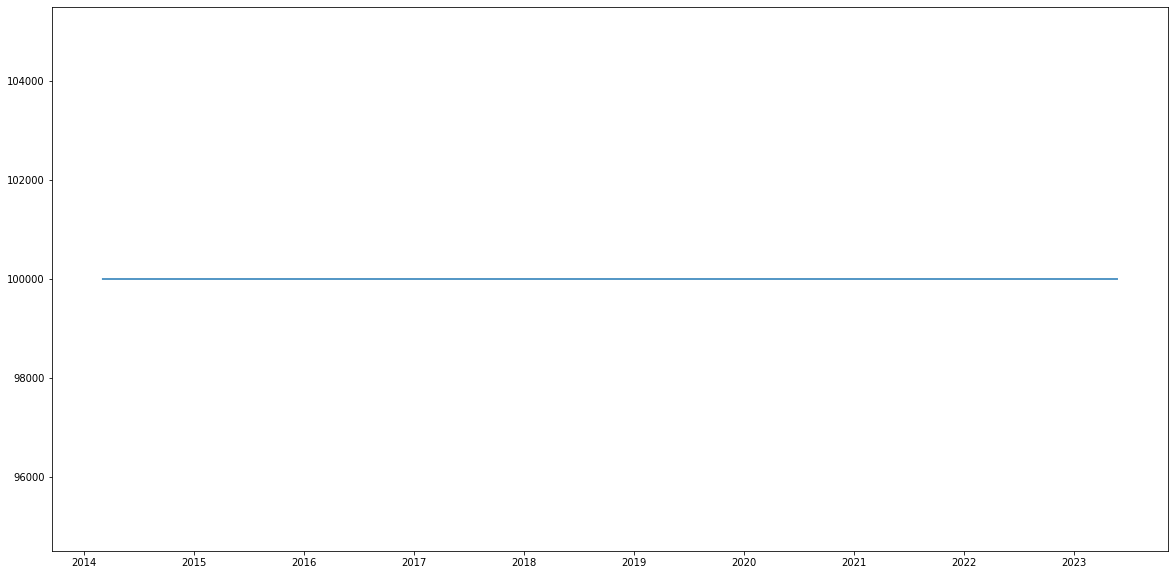

In [69]:
# no shorting backtest

profit = 0
available_capital = 100000
num_shares = 0
floating_portfolios_value = []
dates = temp.index

for i in range(len(temp)):
    
    ## exiting the next day
    available_capital += temp.iloc[i, -3] * num_shares
    num_shares = 0

 
    
    ## opening position
    # longing
    if temp.iloc[i, -1] == 1:
        
        if num_shares == 0:
            
            
            num_shares = available_capital // temp.iloc[i, -3]
            available_capital -= num_shares * temp.iloc[i, -3]
        
            
    # shorting
    elif temp.iloc[i, -1] == -1:
        
        if num_shares == 0:
           
            num_shares = - available_capital // temp.iloc[i, -3]
            available_capital -= num_shares * temp.iloc[i, -3]

        
            
      
    floating_portfolios_value.append(available_capital + num_shares * temp.iloc[i, -3])
    
# plot the floating value
plt.figure(figsize=(20, 10))
plt.plot(dates, floating_portfolios_value)



In [70]:
port_return = (floating_portfolios_value[-1] - 100000) / 100000
port_return

0.0